In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import * #compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo
import lcl
import metpy.calc.kinematics as kine
import metpy.calc as mpcalc
from metpy.units import units

from pdist_fb_distrib_save_fast import *

import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
import warnings; warnings.filterwarnings("ignore")

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]

hourly_file = 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [43]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')    

In [4]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.



In [5]:
# selecting hourly data
wrf_hourly = path + hourly_file
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [6]:
# retrieving SST
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values; 

In [13]:
ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day']

In [7]:
lat = ds_hourly.nav_lat
lon = ds_hourly.nav_lon

In [8]:
# retrievng daily wind

U = xr.open_dataset(wrf_files[files_ls.index('U.nc')]); U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
V = xr.open_dataset(wrf_files[files_ls.index('V.nc')]); V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

U = U.groupby('time_counter.day').mean();  V = V.groupby('time_counter.day').mean()


In [9]:
U, V = 0.5*(U[:,:,:,0:-1]+U[:,:,:,1:]) , 0.5*(V[:,:,0:-1,:]+V[:,:,1:,:])
# U, V = U.where(sea_mask_modified, drop=False), V.where(sea_mask_modified, drop=False)


dx, dy = ds_hourly.attrs['DX'], ds_hourly.attrs['DY']

In [41]:
U_smooth, V_smooth = np.zeros_like(U), np.zeros_like(V)

s = 6

for t in range(0,U_smooth.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,U_smooth.shape[1]):
        U_smooth[t] = gm.nan_gaussian_filter(U[t,h].values,s)                            
        V_smooth[t] = gm.nan_gaussian_filter(V[t,h].values,s)

0
10
20


In [10]:
## using mpcalc to compute divergence
divU = mpcalc.divergence(u=U*units('m/s'), v=V*units('m/s'), dx=dx*units.meters, dy=dy*units.meters ,x_dim=3,y_dim=2)
divU = divU.where(sea_mask_modified, drop=False)

In [44]:
divU_smooth = mpcalc.divergence(u=U_smooth*units('m/s'), v=V_smooth*units('m/s'), dx=dx*units.meters, dy=dy*units.meters ,x_dim=3,y_dim=2)
divU_smooth = divU_smooth*sea_mask_modified_nan 

In [50]:
# PERC DISTRIBUTION divU vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_divU_dsst, pstd_divU_dsst, pstderr_divU_dsst, pnpoints_divU_dsst, ppvalue_divU_dsst_sub = \
dist_3d_subsample(dsst_day.values, divU.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [58]:
ppvalue_divU_dsst_sub[7]

array([3.08717496e-11, 2.91786462e-08, 4.23217017e-13, 9.19024856e-11,
       5.16606757e-11, 4.36026770e-11, 1.39525724e-10, 1.47527435e-09,
       7.66108066e-10, 2.75357515e-11, 6.34452491e-11, 2.03621564e-11,
       1.29443123e-11, 2.01882955e-12, 2.09587903e-12, 1.02429620e-10,
       2.96428659e-10, 3.40048212e-10, 8.25421953e-11, 8.86311025e-11,
       1.87949656e-11, 2.90101276e-12, 4.56301663e-13, 3.17301740e-13,
       8.72635297e-14, 4.26325641e-14, 1.88737914e-14, 3.86357613e-14,
       2.68673972e-14, 4.44089210e-15, 4.88498131e-15, 4.44089210e-16,
       3.10862447e-15, 1.39888101e-14, 9.20374887e-13, 5.07371922e-13,
       5.54001289e-13, 6.78790357e-13, 2.46247467e-13, 4.24105195e-14,
       2.66453526e-15, 4.66293670e-15, 4.44089210e-16, 4.44089210e-16,
       1.57052149e-12, 1.51862523e-10, 2.24092742e-06, 1.08924988e-04,
       8.52300297e-09, 1.48556945e-10])

In [19]:
# PERC DISTRIBUTION divU vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_divU, pstd_divU, pstderr_divU, pnpoints_divU, ppvalue_divU_sub = \
dist_3d_subsample(sst_day, divU.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


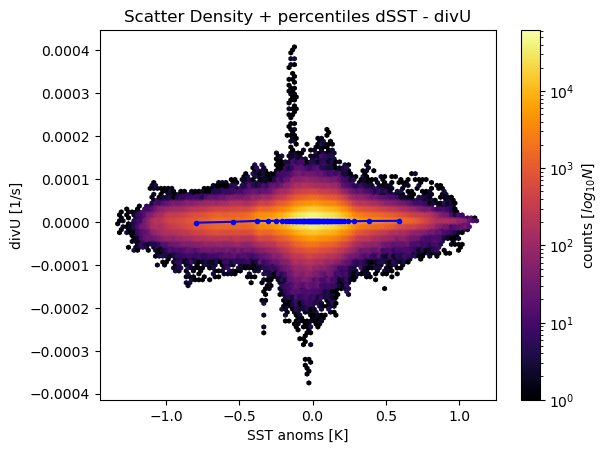

In [88]:
dsst = True

fig, ax1 = plt.subplots()


if not dsst:
    x =  (sst_day-273.15)
    y =  divU.values[:,0,:,:]
#     fit_divU, corcoe_divU, p_value_divU, p_val_cann_divU, sigmas_full_divU = slopes_r_p_mix(x, y, nt, nskip)
    
    title=' Scatter Density + percentiles SST - divU'  
    xlabel='SST [˚C]'
    ylabel='divU [1/s]'
    
else:
    x = dsst_day 
    y = divU.values[:,0,:,:]  
#     fit_divU, corcoe_divU, p_value_divU, p_val_cann_divU, sigmas_divU = slopes_r_p_mix(x, y, nt, nskip)
    
    title='Scatter Density + percentiles dSST - divU'  # and dLCL'
    xlabel='SST anoms [K]'
    ylabel='divU [1/s]'
    

pos = [0.02,0.95]    
    
density_hexbin(x, y, fit=None, corcoe=None, grdsz=100, \
                        title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)

y_pbl = pdist_divU_dsst[0] #if dsst else pdist_PBLH_sst
ax1.plot(pdist_dsst, y_pbl, '.-',color='b')



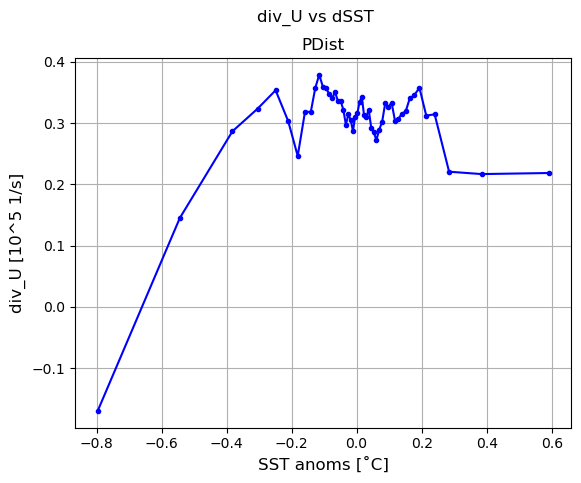

In [92]:
# $\nabla \cdot U$

fig, ax = plt.subplots(1,1)

# PERCENTILES
ax.plot(pdist_dsst, pdist_divU[0]*(10**5), '.-',color='b', label='divU')
ax.set_ylabel('div_U [10^5 1/s]', fontsize=12); 
ax.set_xlabel('SST anoms [˚C]', fontsize=12); 
ax.grid(); 
ax.set_title('PDist')



fig.suptitle('div_U vs dSST')

plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)


#plt.savefig('/venus/tesi_ale/img_EU/distribuzioni_divergenza_dsst.png')

In [11]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values;

# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [15]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day.values, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')



In [16]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

/venus/tesi_ale/img_EU/DIV_U/daily/FEB/NEW_pdist_dsst_divU_lowtropo_2pc_hatch.png


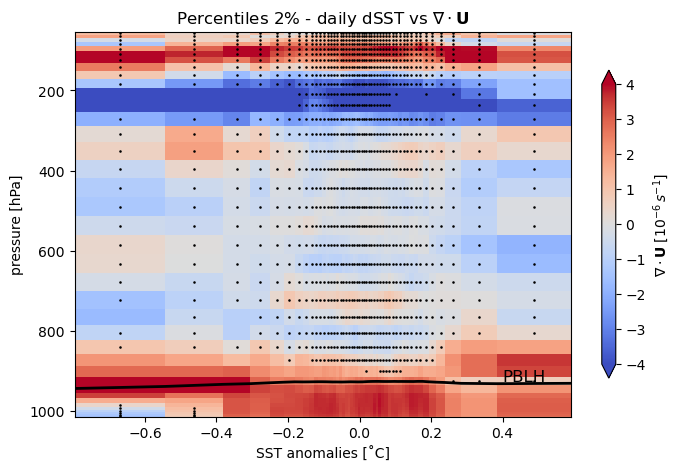

In [51]:
p_level_plot = int(39)

anoms = True
title = r'Percentiles 2% - daily dSST vs $\nabla \cdot \mathbf{U}$' if anoms else r'Percentiles 2% - daily SST vs $\nabla \cdot \mathbf{U}$'
x = pdist_dsst if anoms else pdist_sst-273.15
var = pdist_divU_dsst*1000. if anoms else pdist_divU*1000.
minval = -4 ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot]*1000, vmin=minval, vmax=maxval, cmap='coolwarm')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(title)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r"$\nabla \cdot \mathbf{U}$ [$10^{-6}\,s^{-1}$]")

var_pbl = pdist_PBLH_dsst #if anoms else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 925, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_divU_dsst_sub[0:p_level_plot] #if anoms else pvalue_dQVAPOR_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')




# savefig
path_img = '/venus/tesi_ale/img_EU/DIV_U/daily/FEB/' #if anoms else '/venus/tesi_ale/img_EU/QVAPOR/daily/bins/FEB/'
filename = path_img + 'NEW_pdist_dsst_divU_lowtropo_2pc_hatch.png' #if anoms else path_img + 'bins_dsst_dqvapor_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename

In [31]:
#######   THIS IS TO FIND THE VALUES OF dQVAPOR AT THE LEVEL CLOSEST TO PBLH    #######


where = np.zeros_like(pdist_PBLH_dsst)

for i in range(0, len(pdist_divU_dsst)):
    dist = np.abs(mean_vert_pres - pdist_PBLH_dsst[i])
    min_dist = np.min(dist)
    where[i] = np.argwhere(dist==min_dist).astype(int)

divU_at_pblh = np.zeros_like(pdist_dsst)
stderr_at_pblh = np.zeros_like(pdist_dsst)
std_at_pblh = np.zeros_like(pdist_dsst)

for i in range(0, len(pdist_dsst)):
    divU_at_pblh[i] = pdist_divU_dsst[int(where[i]), i]
    stderr_at_pblh[i] = pstderr_divU_dsst[int(where[i]), i]
    std_at_pblh[i] = pstd_divU_dsst[int(where[i]), i]


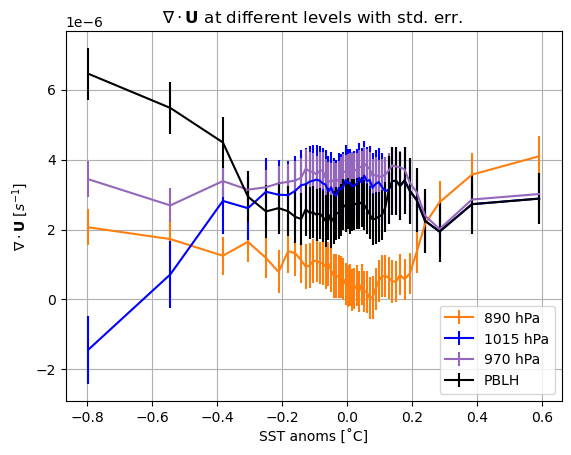

In [40]:
###  QVAPOR SCATTER AT DIFFERENT ALTITUDES  
plt.errorbar(pdist_dsst, pdist_divU_dsst[11,:], yerr=pstderr_divU_dsst[11,:], xerr=None,\
             label='890 hPa', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

plt.errorbar(pdist_dsst, pdist_divU_dsst[0,:], yerr=pstderr_divU_dsst[0,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(pdist_dsst, pdist_divU_dsst[7,:], yerr=pstderr_divU_dsst[7,:], xerr=None,\
             label='970 hPa', ecolor='#9467bd', linestyle='-', color='#9467bd')

plt.errorbar(pdist_dsst, divU_at_pblh, yerr=stderr_at_pblh, xerr=None,\
             label='PBLH', ecolor='k', linestyle='-', color='k')


# plt.errorbar(pdist_dsst, pdist_qc[13,:]*1000, yerr=pstd_qc[13,:]*1000, xerr=None,\
#              label='825 hPa', ecolor='k', linestyle='-', color='k')

# plt.plot(pdist_dsst, qvapor_at_pblh*1000, '.-k', label='PBLH nrst')


# colors = {
#     'Forced HP': '#1f77b4',    # Blue
#     'Forced BP': '#ff7f0e',    # Orange
#     'Coupled HP': '#9467bd',   # Purple
#     'Coupled BP': '#17becf',   # Cyan
# }





plt.legend(loc='lower right')

plt.ylabel(r'$\nabla \cdot \mathbf{U}$ [$s^{-1}$]')
plt.xlabel('SST anoms [˚C]')
plt.title(r'$\nabla \cdot \mathbf{U}$ at different levels with std. err. ')
plt.grid()

In [18]:
# compute anomalies daily data
s = 100

dDivU = np.zeros(divU.shape)

for t in range(0,dDivU.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,dDivU.shape[1]):
        q_ave = gm.nan_gaussian_filter(divU[t,h].values,s)                            
        dDivU[t,h] = divU[t,h].values - q_ave

0
10
20


In [22]:
# PERC DISTRIBUTION divU vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_ddivU_dsst, pstd_ddivU_dsst, pstderr_ddivU_dsst, pnpoints_ddivU_dsst, ppvalue_ddivU_dsst_sub = \
dist_3d_subsample(dsst_day.values, dDivU, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


/venus/tesi_ale/img_EU/DIV_U/daily/FEB/NEW_pdist_dsst_dDivU_lowtropo_2pc.png


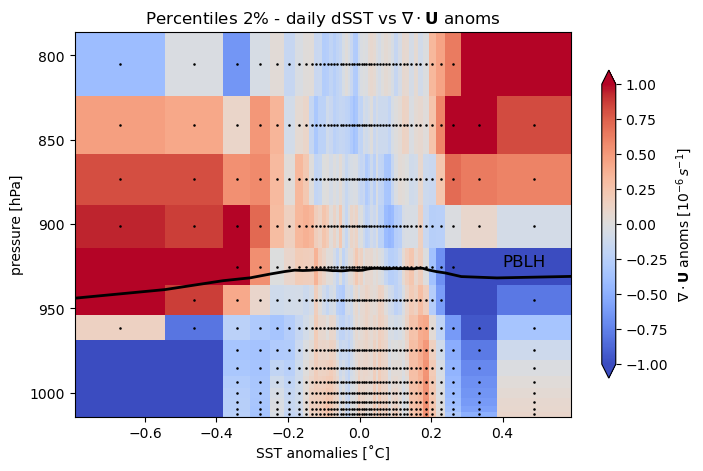

In [24]:
p_level_plot = int(15)

anoms = True
title = r'Percentiles 2% - daily dSST vs $\nabla \cdot \mathbf{U}$ anoms' #if anoms else r'Percentiles 2% - daily SST vs $\nabla \cdot \mathbf{U}$'
x = pdist_dsst #if anoms else pdist_sst-273.15
var = pdist_ddivU_dsst*1000. #if anoms else pdist_divU*1000.
minval = -1 ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot]*1000, vmin=minval, vmax=maxval, cmap='coolwarm')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(title)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r"$\nabla \cdot \mathbf{U}$ anoms [$10^{-6}\,s^{-1}$]")

var_pbl = pdist_PBLH_dsst #if anoms else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 925, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_ddivU_dsst_sub[0:p_level_plot] #if anoms else pvalue_dQVAPOR_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')




# savefig
path_img = '/venus/tesi_ale/img_EU/DIV_U/daily/FEB/' #if anoms else '/venus/tesi_ale/img_EU/QVAPOR/daily/bins/FEB/'
filename = path_img + 'NEW_pdist_dsst_dDivU_lowtropo_2pc.png' #if anoms else path_img + 'bins_dsst_dqvapor_lowtropo_hatch.png'
plt.savefig(filename)
print(filename)
del filename